In [2]:
import torch
import os 
import torch.optim as optim
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [3]:
sys.path.append('/remote/tychodata/ftairli/work/Projects/TraceHexConv/Models')


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using ',device)



Using  cuda:0


In [5]:
#  Load the data

D_main = torch.load('../Data/NormData/D_main_test.pt')
if D_main.is_sparse: D_main = D_main.to_dense()
D_aux  = torch.load('../Data/NormData/D_aux_test.pt')
logE   = torch.load('../Data/NormData/logE_test.pt')
Core   = torch.load('../Data/NormData/Core_test.pt')
Axis   = torch.load('../Data/NormData/Axis_test.pt')
Xmax   = torch.load('../Data/NormData/Xmax_test.pt')

In [6]:
print(D_main.shape)

torch.Size([23681, 120, 3, 11, 11])


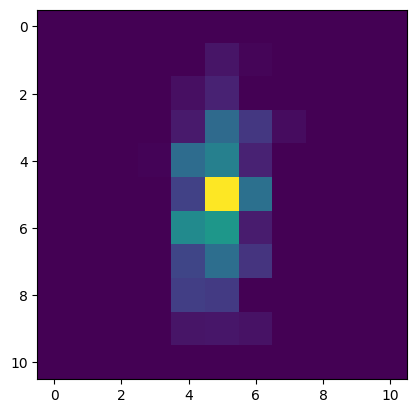

In [40]:
N = np.random.randint(0,D_main.shape[0])
plt.imshow(D_main[N].sum(dim=[0,1]))


In [ ]:
class Trace_Block(nn.Module):
    def __init__(self, in_channels=3, hidden_dim = 20, features =12):
        super(Trace_Block, self).__init__()

        self.bi_lstm = nn.LSTM(input_size=in_channels, 
                                hidden_size=hidden_dim, 
                                batch_first=True, 
                                bidirectional=True)
        
        self.lstm = nn.LSTM(input_size=hidden_dim*2, # 2 for bidirection
                            hidden_size=hidden_dim,
                            batch_first=True)
        self.CollectLSTM = nn.LSTM(input_size=hidden_dim,
                                    hidden_size=features,
                                    batch_first=True)
        self.features = features

    def forward(self,x):
        # Read parameters of input
        # print(x.shape)
        N,H,W,L,C = x.shape                 # Shape = N,H,W,L,C
        x = x.reshape(N*H*W,L,C)            # Shape = N*H*W,L,C

        out,_ = self.bi_lstm(x)             # Shape = N*H*W,L,hidden_dim*2
        out,_ = self.lstm(out)              # Shape = N*H*W,L,hidden_dim
        out,_ = self.CollectLSTM(out)       # Shape = N*H*W,L,features
        out = out[:,-1,:]                   # Shape = N*H*W,features (Only care about the final timestep here, aka "parameter")
        out = out.reshape(N,H,W,self.features) # Shape = N,H,W,features
        out = out.permute(0,3,1,2)          # Shape = N,features,H,W
        return out


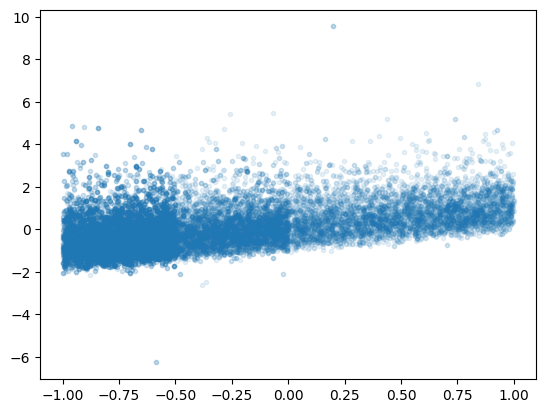

In [48]:
plt.scatter(logE[:,0],Xmax[:,0],marker = '.',alpha=0.1)